In [ ]:
#----------------------------------------IMPORT LIABARIES----------------------------------------------
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.datasets import cifar10
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,  accuracy_score
import cv2

import glob
import os
import PIL
import time

from IPython import display

Shape after conv2d_1: (None, 16, 16, 32)
Shape after conv2d_2: (None, 8, 8, 64)
Shape after flatten: (None, 4096)
Shape after dense_out: (None, 1)
Epoch 1 completed.


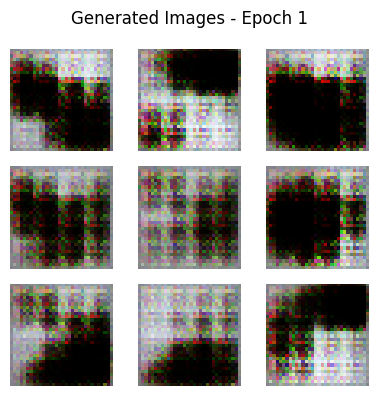

Epoch 2 completed.


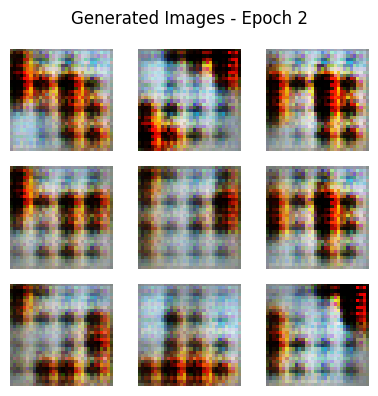

Epoch 3 completed.


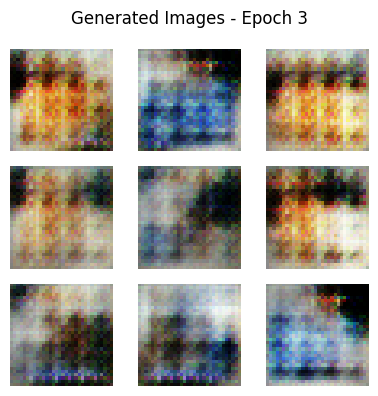

Epoch 4 completed.


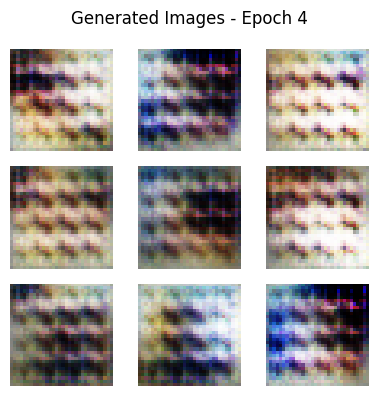

Training finished.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
NOISE_DIM = 32
BATCH_SIZE = 64
BUFFER_SIZE = 10000
OUTPUT_CHANNELS = 3
EPOCHS = 4

# Load CIFAR-10
(real_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
real_images = (real_images.astype('float32') - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(real_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Simpler Generator
def make_generator_model_cpu_friendly():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4 * 4 * 128, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((4, 4, 128)))

    model.add(layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False))  # 4x4 -> 8x8
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, 4, strides=2, padding='same', use_bias=False))  # 8x8 -> 16x16
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', activation='tanh', use_bias=False))  # 16x16 -> 32x32
    return model

# Simpler Discriminator
def make_discriminator_model_cpu_friendly_debug():
    model = tf.keras.Sequential(name="discriminator_debug")
    model.add(layers.Conv2D(32, 4, strides=2, padding='same', input_shape=[32, 32, OUTPUT_CHANNELS], name="conv2d_1"))
    print(f"Shape after conv2d_1: {model.output_shape}")
    model.add(layers.LeakyReLU(name="leaky_relu_1"))
    model.add(layers.Dropout(0.3, name="dropout_1"))

    model.add(layers.Conv2D(64, 4, strides=2, padding='same', name="conv2d_2"))
    print(f"Shape after conv2d_2: {model.output_shape}")
    model.add(layers.LeakyReLU(name="leaky_relu_2"))
    model.add(layers.Dropout(0.3, name="dropout_2"))

    model.add(layers.Flatten(name="flatten"))
    print(f"Shape after flatten: {model.output_shape}")

    model.add(layers.Dense(1, name="dense_out"))
    print(f"Shape after dense_out: {model.output_shape}")
    return model


# Loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss_simple(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss
def generator_loss_simple(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
generator_optimizer_simple = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer_simple = tf.keras.optimizers.Adam(1e-4)

# Training step
@tf.function
def train_step_simple(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_simple(noise, training=True)
        real_output = discriminator_simple(images, training=True)
        fake_output = discriminator_simple(generated_images, training=True)
        gen_loss = generator_loss_simple(fake_output)
        disc_loss = discriminator_loss_simple(real_output, fake_output)
    gradients_generator = gen_tape.gradient(gen_loss, generator_simple.trainable_variables)
    gradients_discriminator = disc_tape.gradient(disc_loss, discriminator_simple.trainable_variables)
    generator_optimizer_simple.apply_gradients(zip(gradients_generator, generator_simple.trainable_variables))
    discriminator_optimizer_simple.apply_gradients(zip(gradients_discriminator, discriminator_simple.trainable_variables))

# Generate and plot
def generate_and_plot(model, epoch, test_input):
    predictions = model(test_input)
    fig = plt.figure(figsize=(4, 4))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = (predictions[i] * 127.5 + 127.5).numpy().astype("uint8")
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Generated Images - Epoch {epoch+1}")
    plt.tight_layout()
    plt.show()

# Training loop
noise_seed = tf.random.normal([9, NOISE_DIM])
generator_simple = make_generator_model_cpu_friendly()
discriminator_simple = make_discriminator_model_cpu_friendly_debug()

for epoch in range(EPOCHS):
    for image_batch in train_dataset:
        train_step_simple(image_batch)
    print(f"Epoch {epoch + 1} completed.")
    generate_and_plot(generator_simple, epoch, noise_seed)

print("Training finished.")

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 76s 95ms/step - accuracy: 0.4140 - loss: 1.6421 - val_accuracy: 0.5718 - val_loss: 1.2324
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - accuracy: 0.6094 - loss: 1.1175 - val_accuracy: 0.5935 - val_loss: 1.1645
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.6684 - loss: 0.9493 - val_accuracy: 0.6161 - val_loss: 1.1062
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.7243 - loss: 0.7997 - val_accuracy: 0.6205 - val_loss: 1.0979
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 93ms/step - accuracy: 0.7699 - loss: 0.6692 - val_accuracy: 0.6213 - val_loss: 1.1527
Simple classifier training completed.


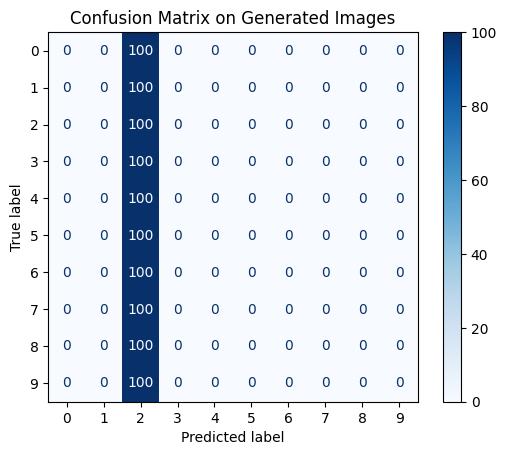

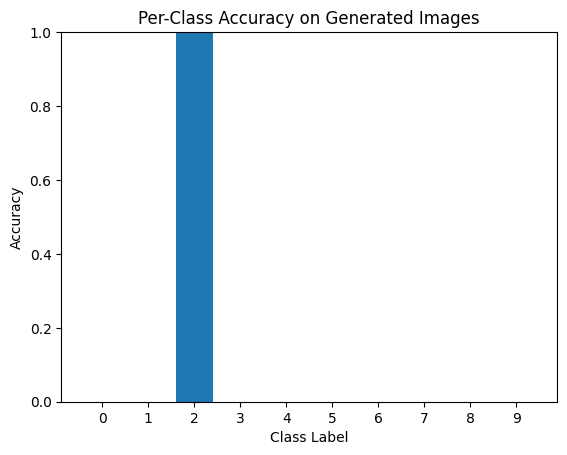

Overall Accuracy on Generated Images: 10.00%


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2DTranspose, Reshape, BatchNormalization, LeakyReLU, Conv2D, Dropout, Embedding, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Define the Generator (simplified for CPU and speed)
def make_generator(noise_dim=100, num_classes=10):
    label_input = tf.keras.Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(num_classes, 50)(label_input)
    label_embedding = Flatten()(label_embedding)

    noise_input = tf.keras.Input(shape=(noise_dim,))
    merged_input = Concatenate()([noise_input, label_embedding])

    x = Dense(4 * 4 * 128)(merged_input)
    x = Reshape((4, 4, 128))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(128, 4, strides=2, padding='same')(x)  # 8x8
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, 4, strides=2, padding='same')(x)  # 16x16
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(32, 4, strides=2, padding='same')(x)  # 32x32
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(3, 3, strides=1, padding='same', activation='tanh')(x)  # Final output
    return tf.keras.Model([noise_input, label_input], x)




# Load and preprocess CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

# Normalize input for a simple classifier [0, 1]
x_train_norm = x_train.astype('float32') / 255.0
x_test_norm = x_test.astype('float32') / 255.0

# Define a simple classifier for evaluation

simple_classifier = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])


# Compile the simple classifier
simple_classifier.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

# Train the simple classifier (briefly)
simple_classifier.fit(x_train_norm, y_train_cat, epochs=5, batch_size=64, validation_data=(x_test_norm, y_test_cat), verbose=1)

print("Simple classifier training completed.")

noise_dim = 100
generator = make_generator(noise_dim=noise_dim)

# Define evaluation function for the generator using the simple classifier
def evaluate_generator_with_simple_classifier(generator, classifier, noise_dim=100, samples_per_class=100):
    NUM_CLASSES = 10

    # Create balanced label set
    labels_np = np.repeat(np.arange(NUM_CLASSES), samples_per_class)
    labels = tf.convert_to_tensor(labels_np.reshape(-1, 1), dtype=tf.int32)
    noise = tf.random.normal([labels.shape[0], noise_dim])

    # Generate images
    generated_images = generator([noise, labels], training=False)
    # Scale from [-1, 1] to [0, 1] for the simple classifier
    generated_images = (generated_images + 1) / 2.0

    # Classify generated images
    preds = classifier.predict(generated_images, batch_size=32, verbose=0)
    pred_labels = np.argmax(preds, axis=1)
    true_labels = labels.numpy().flatten()

    # Compute metrics
    cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(NUM_CLASSES))
    acc = accuracy_score(true_labels, pred_labels)

    # Confusion matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUM_CLASSES)])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix on Generated Images")
    plt.show()

    # Per-class accuracy
    class_accs = cm.diagonal() / cm.sum(axis=1)
    plt.bar(np.arange(NUM_CLASSES), class_accs)
    plt.xlabel("Class Label")
    plt.ylabel("Accuracy")
    plt.title("Per-Class Accuracy on Generated Images")
    plt.ylim([0, 1])
    plt.xticks(np.arange(NUM_CLASSES))
    plt.show()

    print(f"Overall Accuracy on Generated Images: {acc:.2%}")

# Evaluate the generator using the simple classifier
evaluate_generator_with_simple_classifier(generator, simple_classifier, noise_dim=noise_dim)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 28ms/step - accuracy: 0.3695 - loss: 1.7562 - val_accuracy: 0.4941 - val_loss: 1.4083
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 25ms/step - accuracy: 0.5605 - loss: 1.2582 - val_accuracy: 0.5647 - val_loss: 1.2448
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.6026 - loss: 1.1431 - val_accuracy: 0.5613 - val_loss: 1.2436
Simple classifier training completed.


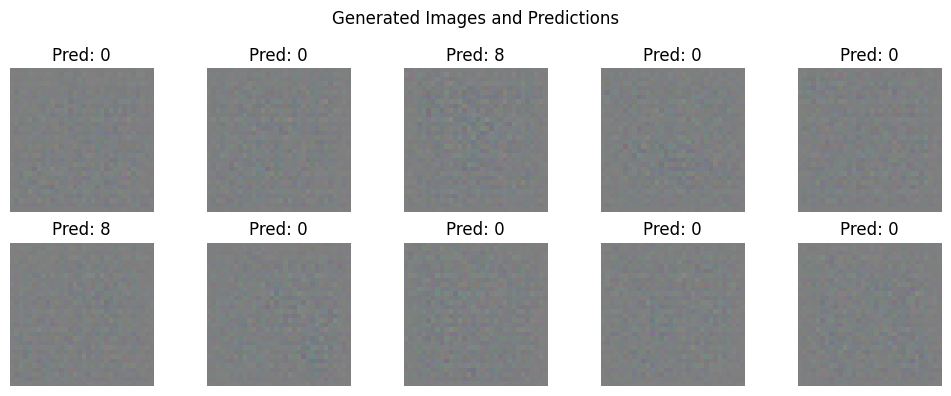

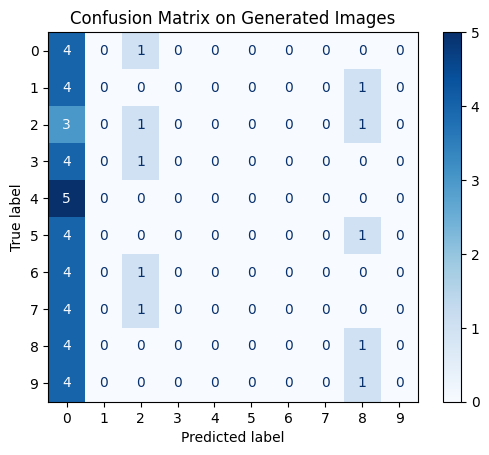

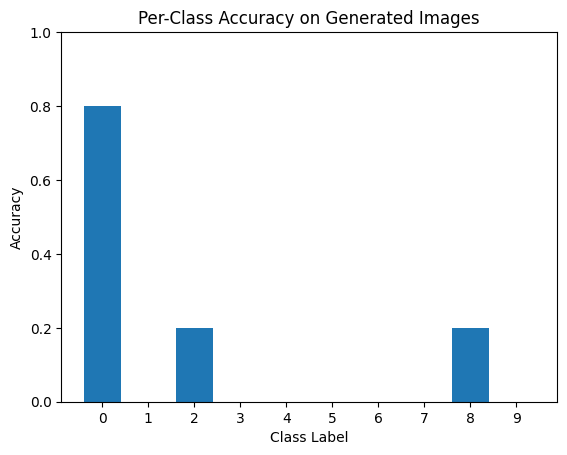

Overall Accuracy on Generated Images: 12.00%


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2DTranspose, Reshape, BatchNormalization, LeakyReLU, Conv2D, Dropout, Embedding, Concatenate
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Define the Generator (simplified for CPU and speed)
def make_generator(noise_dim=100, num_classes=10):
    label_input = tf.keras.Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(num_classes, 50)(label_input)
    label_embedding = Flatten()(label_embedding)

    noise_input = tf.keras.Input(shape=(noise_dim,))
    merged_input = Concatenate()([noise_input, label_embedding])

    x = Dense(4 * 4 * 64)(merged_input)
    x = Reshape((4, 4, 64))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(32, 4, strides=2, padding='same')(x)  # 8x8
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(16, 4, strides=2, padding='same')(x)  # 16x16
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(x)  # 32x32
    return tf.keras.Model([noise_input, label_input], x)

# Load and preprocess CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

# Normalize input for a simple classifier [0, 1]
x_train_norm = x_train.astype('float32') / 255.0
x_test_norm = x_test.astype('float32') / 255.0

# Define a simple classifier for evaluation
simple_classifier = Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the simple classifier
simple_classifier.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

# Train the simple classifier (briefly)
simple_classifier.fit(x_train_norm, y_train_cat, epochs=3, batch_size=32, validation_data=(x_test_norm, y_test_cat), verbose=1)

print("Simple classifier training completed.")

# Instantiate the generator (you would normally load your trained generator here)
# For demonstration, we'll create an untrained generator
noise_dim = 100
generator = make_generator(noise_dim=noise_dim)

# Define evaluation function for the generator using the simple classifier
def evaluate_generator_with_simple_classifier(generator, classifier, num_classes=10, samples_per_class=5):
    all_preds = []
    all_true = []
    generated_images_for_plot = []
    predicted_labels_for_plot = []

    for i in range(num_classes):
        labels = tf.constant([[i]] * samples_per_class, dtype=tf.int32)
        noise = tf.random.normal([samples_per_class, noise_dim])
        generated_images = generator([noise, labels], training=False)
        scaled_images = (generated_images + 1) / 2.0
        preds = classifier.predict(scaled_images, verbose=0)
        pred_labels = np.argmax(preds, axis=1)
        true_labels = np.full(samples_per_class, i)

        all_preds.extend(pred_labels)
        all_true.extend(true_labels)

        # Store a few images and their predictions for plotting
        if len(generated_images_for_plot) < num_classes:
            generated_images_for_plot.append(scaled_images[0].numpy())
            predicted_labels_for_plot.append(pred_labels[0])

    # Compute metrics
    cm = confusion_matrix(all_true, all_preds, labels=np.arange(num_classes))
    acc = accuracy_score(all_true, all_preds)
    class_accs = cm.diagonal() / cm.sum(axis=1)

    # Plotting
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        if i < num_classes:
            ax.imshow(generated_images_for_plot[i])
            ax.set_title(f"Pred: {predicted_labels_for_plot[i]}")
            ax.axis('off')
        else:
            ax.axis('off')
    plt.suptitle("Generated Images and Predictions")
    plt.tight_layout()
    plt.show()

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(num_classes)])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix on Generated Images")
    plt.show()

    plt.bar(np.arange(num_classes), class_accs)
    plt.xlabel("Class Label")
    plt.ylabel("Accuracy")
    plt.title("Per-Class Accuracy on Generated Images")
    plt.ylim([0, 1])
    plt.xticks(np.arange(num_classes))
    plt.show()

    print(f"Overall Accuracy on Generated Images: {acc:.2%}")

# Evaluate the generator using the simple classifier
evaluate_generator_with_simple_classifier(generator, simple_classifier, num_classes=10, samples_per_class=5)